In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [3]:
from tcpips.constants import DATA_PATH, CMIP6_PATH, RAW_PATH, REGRIDDED_PATH, BIAS_CORRECTED_PATH, FIGURE_PATH

In [4]:
import os

In [5]:
MODELS = ["CESM2"]

In [6]:
# ocean_model_ensemble_paths = []
import xarray as xr

def regrid_ocean(in_path, out_path):
    print(in_path), print(out_path)
    ds = xr.open_dataset(in_path)
    print(ds)


for model in MODELS:
    model_path = os.path.join(RAW_PATH, "ssp585", "ocean", model)
    print(model_path)
    for file in os.listdir(model_path):
        print(file)
        regrid_ocean(os.path.join(model_path, file), os.path.join(REGRIDDED_PATH, "ssp585", "ocean", model, file))



/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/adcirc-swan/worstsurge/data/cmip6/raw/ssp585/ocean/CESM2
r4i1p1f1.nc
/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/adcirc-swan/worstsurge/data/cmip6/raw/ssp585/ocean/CESM2/r4i1p1f1.nc
/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/adcirc-swan/worstsurge/data/cmip6/regridded/ssp585/ocean/CESM2/r4i1p1f1.nc
<xarray.Dataset> Size: 515MB
Dimensions:         (time: 1032, y: 384, x: 320, bnds: 2, vertex: 4)
Coordinates:
    lat             (y, x) float64 983kB ...
    lon             (y, x) float64 983kB ...
  * time            (time) object 8kB 2015-01-15 13:00:00 ... 2100-12-15 12:0...
    time_bounds     (time, bnds) object 17kB ...
    lon_verticies   (y, x, vertex) float32 2MB ...
    lat_verticies   (y, x, vertex) float32 2MB ...
  * y               (y) int64 3kB 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
  * x               (x) int64 3kB 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
    lon_bounds      (bnds, y, x) float32 983kB ...
    lat_bounds   

In [7]:
from sithom.time import timeit
import matplotlib.pyplot as plt
import xesmf as xe
from tcpips.constants import CMIP6_PATH
from sithom.plot import plot_defaults
# from tcpips.conver
from tcpips.constants import CONVERSION_NAMES

@timeit
def regrid_1d(xesmf: bool = False) -> None:
    """
    Regrid 1d data.

    Args:
        xesmf (bool, optional): Defaults to False.
    """

    def open_1d(path: str):
        ds = xr.open_dataset(path)
        # plt.imshow(ds.lat.values)
        #
        # plt.imshow(ds.lon.values)
        #
        # print("ds", name, ds)
        ds = ds.drop_vars(
            [
                x
                for x in [
                    "lon",
                    "lat",
                    "lat_verticies",
                    "lon_verticies",
                    "lon_bounds",
                    "time_bounds",
                    "lat_bounds",
                    "CMIP6_PATH",
                    "member_id",
                ]
                if x in ds
            ]
        ).isel(y=slice(1, -1))
        if xesmf:
            ds = ds.assign_coords({"lon": ds["x"], "lat": ds["y"]})
            return ds.drop_vars(["x", "y"])
        else:
            return ds.rename({"x": "lon", "y": "lat"})

    ocean_ds = open_1d(os.path.join(CMIP6_PATH, "ocean.nc"))
    print("ocean_ds", ocean_ds)
    ocean_ds.isel(time=0).tos.plot(x="lon", y="lat")


    new_coords = atmos_ds[["lon", "lat"]]
    print("new_coords", new_coords)
    plt.plot(new_coords.lat.values, label="new")
    plt.plot(ocean_ds.lat.values, label="ocean")
    plt.legend()
    plt.title("lat")

    plt.plot(new_coords.lon.values, label="new")
    plt.plot(ocean_ds.lon.values, label="ocean")
    plt.legend()
    plt.title("lon")

    if xesmf:
        regridder = xe.Regridder(ocean_ds, new_coords, "nearest_s2d", periodic=True)
        print(regridder)
        ocean_out = regridder(
            ocean_ds,  # .drop_vars(["x", "y"]).set_coords(["lon", "lat"]),
            keep_attrs=True,
            skipna=True,
        )
    else:
        ocean_out = ocean_ds.interp(
            {"lon": new_coords.lon.values, "lat": new_coords.lat.values},
            method="nearest",
        )
    print("ocean_out", ocean_out)
    ocean_out.to_netcdf(os.path.join(CMIP6_PATH, "regrid1d_ocean_regridded.nc"))
    ocean_out.tos.isel(time=0).plot(x="lon", y="lat")
    plt.savefig(os.path.join(FIGURE_PATH, "ocean_regridded_regrid1d.png"))

In [2]:
from sithom.time import timeit
from sithom.plot import plot_defaults
from sithom.misc import in_notebook
from tcpips.constants import CONVERSION_NAMES, RAW_PATH, CMIP6_PATH, REGRIDDED_PATH
import xarray as xr
import xesmf as xe
import os

@timeit
def regrid_any(output_res: float = 1.0, time_chunk: int = 10, exp: str="ssp585", typ: str="ocean", model: str ="CESM2",member: str="r4i1p1f1") -> None:
    """
    Regrid 2d data to 1 degree resolution.

    Args:
        output_res (float, optional): Resolution of the output grid. Defaults to 1.0.
        time_chunk (int, optional): Chunk size for time. Defaults to 10.
    """
    plot_defaults()

    def open_ds(path: str) -> xr.Dataset:
        """
        Open dataset.

        Args:
            path (str): path to the dataset.

        Returns:
            xr.Dataset: xarray dataset.
        """
        nonlocal time_chunk
        # open netcdf4 file using dask backend
        ds = xr.open_dataset(path, chunks={"time": time_chunk})
        ds = ds.drop_vars(
            [
                x
                for x in [
                    "x",
                    "y",
                    "dcpp_init_year",
                    "member_id",
                ]
                if x in ds
            ]
        )
        return ds

    in_ds = open_ds(os.path.join(RAW_PATH, exp, typ, model, member)+".nc").isel(time=slice(0, 10))
    # atmos_ds = open_ds(os.path.join(RAW_PATH, "ssp585", "atmos", "CESM2", 'r4i1p1f1.nc'))

    new_coords = xe.util.grid_global(
        output_res, output_res
    )  # make regular lat/lon grid

    def regrid_and_save(input_ds: xr.Dataset, output_name: str) -> xr.Dataset:
        """
        Regrid and save the input dataset to the output.

        Args:
            input_ds (xr.Dataset): dataset to regrid.
            output_name (str): of the output file.

        Returns:
            xr.Dataset: regridded dataset.
        """
        regridder = xe.Regridder(
            input_ds, new_coords, "bilinear", periodic=True, ignore_degenerate=True
        )
        print(regridder)
        out_ds = regridder(
            input_ds,
            keep_attrs=True,
            skipna=True,
            # ignore_degenerate=True,
        )
        delayed_obj = out_ds.to_netcdf(
            os.path.join(CMIP6_PATH, output_name),
            format="NETCDF4",
            engine="h5netcdf",  # should be better at parallel writing/dask
            chunks={"time": time_chunk},
            encoding={
                var: {"dtyp": "float32", "zlib": True, "complevel": 6}
                for var in CONVERSION_NAMES.keys()
                if var in out_ds
            },
            compute=False,
        )
        with ProgressBar():
            results = delayed_obj.compute()        
        return out_ds  # return for later plotting.
    
    folder = os.path.join(REGRIDDED_PATH, exp, typ, model)
    os.makedirs(folder, exist_ok=True)
    out_ds = regrid_and_save(
        in_ds, os.path.join(folder, member)+ ".nc"
    )
    print("out_ds", out_ds)
    if typ == "ocean" and in_notebook():
        out_ds.tos.isel(time=0).plot(x="lon", y="lat")
        plt.show()
        out_ds.tos.isel(time=0).plot()
        plt.show()
    elif typ == "atmos" and in_notebook():
        out_ds.tas.isel(time=0, p=0).plot(x="lon", y="lat")
        plt.show()

In [ ]:
os.listdir(os.path.join(RAW_PATH, "ssp585", "atmos", "CESM2"))

['r4i1p1f1.nc', 'r10i1p1f1.nc', 'r11i1p1f1.nc']

In [3]:
regrid_any(output_res = 0.5, time_chunk = 1)

/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_384x320_360x720_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (360, 720) 
Periodic in longitude?      True


/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/computation.py:452: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 540.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (24, 20).
  result_vars[name] = func(*variable_args)
/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/dask/array/routines.py:332: PerformanceWarning: Increasing number of chunks by factor of 540
  intermediate = blockwise(


: 

: 

: 

In [1]:
from tcpips.regrid import regrid_any

In [2]:
from tcpips.regrid import define_tasks

In [3]:
define_tasks()

'define_tasks'  0.03589 s 



{'ssp585.ocean.CESM2.r4i1p1f1.nc': {'exp': 'ssp585',
  'typ': 'ocean',
  'model': 'CESM2',
  'member': 'r4i1p1f1.nc',
  'regridded_exists': False,
  'locked': False},
 'ssp585.ocean.CESM2.r10i1p1f1.nc': {'exp': 'ssp585',
  'typ': 'ocean',
  'model': 'CESM2',
  'member': 'r10i1p1f1.nc',
  'regridded_exists': False,
  'locked': False},
 'ssp585.ocean.CESM2.r11i1p1f1.nc': {'exp': 'ssp585',
  'typ': 'ocean',
  'model': 'CESM2',
  'member': 'r11i1p1f1.nc',
  'regridded_exists': False,
  'locked': False},
 'ssp585.ocean.CIESM.r1i1p1f1.nc': {'exp': 'ssp585',
  'typ': 'ocean',
  'model': 'CIESM',
  'member': 'r1i1p1f1.nc',
  'regridded_exists': False,
  'locked': False},
 'ssp585.atmos.CESM2.r4i1p1f1.nc': {'exp': 'ssp585',
  'typ': 'atmos',
  'model': 'CESM2',
  'member': 'r4i1p1f1.nc',
  'regridded_exists': False,
  'locked': False},
 'ssp585.atmos.CESM2.r10i1p1f1.nc': {'exp': 'ssp585',
  'typ': 'atmos',
  'model': 'CESM2',
  'member': 'r10i1p1f1.nc',
  'regridded_exists': False,
  'locked': 

In [ ]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

'define_tasks'  0.00374 s 

tasks {'ssp585.ocean.CESM2.r4i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CESM2', 'member': 'r4i1p1f1', 'regridded_exists': True, 'locked': False}, 'ssp585.ocean.CESM2.r10i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CESM2', 'member': 'r10i1p1f1', 'regridded_exists': True, 'locked': True}, 'ssp585.ocean.CESM2.r11i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CESM2', 'member': 'r11i1p1f1', 'regridded_exists': False, 'locked': False}, 'ssp585.ocean.CIESM.r1i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CIESM', 'member': 'r1i1p1f1', 'regridded_exists': False, 'locked': False}, 'ssp585.atmos.CESM2.r4i1p1f1': {'exp': 'ssp585', 'typ': 'atmos', 'model': 'CESM2', 'member': 'r4i1p1f1', 'regridded_exists': False, 'locked': False}, 'ssp585.atmos.CESM2.r10i1p1f1': {'exp': 'ssp585', 'typ': 'atmos', 'model': 'CESM2', 'member': 'r10i1p1f1', 'regridded_exists': False, 'locked': False}, 'ssp585.atmos.CESM2.r11i1p1f1': {'exp': 'ssp585', 'typ': 'atmo

/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


'open_ds'  01 min 20 s 

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_384x320_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True


/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/computation.py:452: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 144.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (24, 20).
  result_vars[name] = func(*variable_args)
/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


[########################################] | 100% Completed | 133.69 s
'regrid_and_save'  03 min 41 s 

out_ds <xarray.Dataset> Size: 6MB
Dimensions:      (time: 10, y: 180, x: 360, bnds: 2)
Coordinates:
  * time         (time) object 80B 2015-01-15 13:00:00 ... 2015-10-15 12:00:00
    time_bounds  (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon          (y, x) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat          (y, x) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Dimensions without coordinates: y, x, bnds
Data variables:
    tos          (time, y, x) float64 5MB dask.array<chunksize=(10, 24, 20), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    case_id:                      

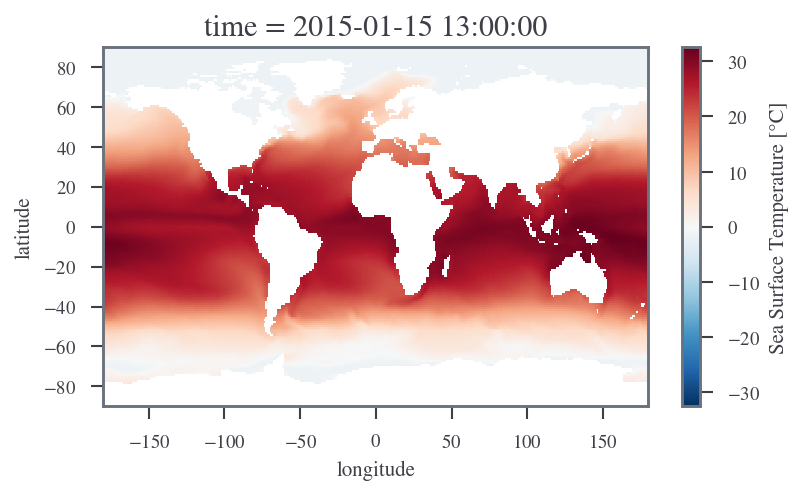

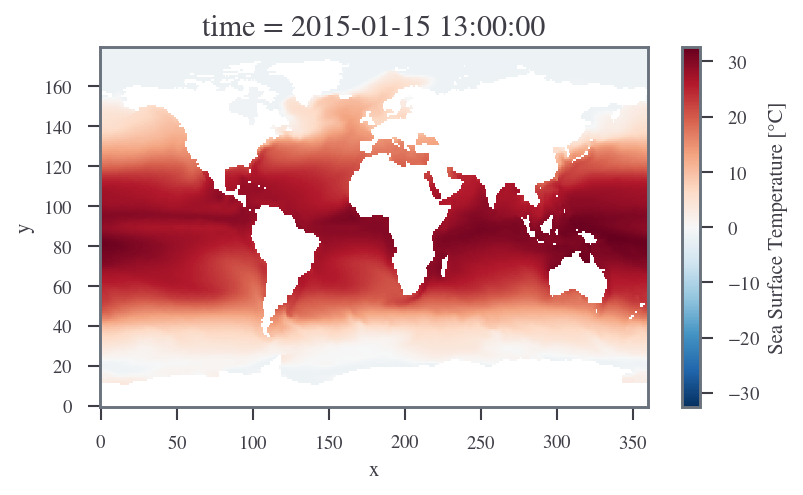

'regrid_any'  07 min 44 s 

Regridding ssp585.ocean.CIESM.r1i1p1f1


/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


'open_ds'  13.64162 s 

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_384x320_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True


/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/computation.py:452: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 144.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (24, 20).
  result_vars[name] = func(*variable_args)


[########################################] | 100% Completed | 100.25 s
'regrid_and_save'  02 min 20 s 

out_ds <xarray.Dataset> Size: 6MB
Dimensions:      (time: 10, y: 180, x: 360, bnds: 2)
Coordinates:
  * time         (time) object 80B 2015-01-16 12:00:00 ... 2015-10-16 12:00:00
    time_bounds  (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon          (y, x) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat          (y, x) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Dimensions without coordinates: y, x, bnds
Data variables:
    tos          (time, y, x) float64 5MB dask.array<chunksize=(10, 24, 20), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    cmor_version:                 

KeyboardInterrupt: 

In [1]:
from tcpips.regrid import run_tasks
run_tasks()

'define_tasks'  0.00768 s 

tasks {'ssp585.ocean.CESM2.r4i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CESM2', 'member': 'r4i1p1f1', 'regridded_exists': True, 'locked': False}, 'ssp585.ocean.CESM2.r10i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CESM2', 'member': 'r10i1p1f1', 'regridded_exists': True, 'locked': False}, 'ssp585.ocean.CESM2.r11i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CESM2', 'member': 'r11i1p1f1', 'regridded_exists': True, 'locked': False}, 'ssp585.ocean.CIESM.r1i1p1f1': {'exp': 'ssp585', 'typ': 'ocean', 'model': 'CIESM', 'member': 'r1i1p1f1', 'regridded_exists': True, 'locked': False}, 'ssp585.atmos.CESM2.r4i1p1f1': {'exp': 'ssp585', 'typ': 'atmos', 'model': 'CESM2', 'member': 'r4i1p1f1', 'regridded_exists': False, 'locked': False}, 'ssp585.atmos.CESM2.r10i1p1f1': {'exp': 'ssp585', 'typ': 'atmos', 'model': 'CESM2', 'member': 'r10i1p1f1', 'regridded_exists': False, 'locked': False}, 'ssp585.atmos.CESM2.r11i1p1f1': {'exp': 'ssp585', 'typ': 'atmos

/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


'open_ds'  42.63688 s 

in_ds <xarray.Dataset> Size: 13MB
Dimensions:        (time: 10, y: 384, x: 320, bnds: 2, vertex: 4)
Coordinates:
    lat            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time           (time) object 80B 2015-01-15 13:00:00 ... 2015-10-15 12:00:00
    time_bounds    (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 983kB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 983kB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
Dimensions without coordinates: y, x, bnds, vertex
Data variables:
    tos            (time, y, x) float32 5MB dask

/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/xarray/core/computation.py:452: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 540.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (24, 20).
  result_vars[name] = func(*variable_args)
/mnt/lustre/a2fs-work2/work/n02/n02/sdat2/micromamba/envs/t1/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


[########################################] | 100% Completed | 445.44 s
'regrid_and_save'  08 min 58 s 

out_ds <xarray.Dataset> Size: 25MB
Dimensions:      (time: 10, y: 360, x: 720, bnds: 2)
Coordinates:
  * time         (time) object 80B 2015-01-15 13:00:00 ... 2015-10-15 12:00:00
    time_bounds  (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon          (y, x) float64 2MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    lat          (y, x) float64 2MB dask.array<chunksize=(360, 720), meta=np.ndarray>
Dimensions without coordinates: y, x, bnds
Data variables:
    tos          (time, y, x) float64 21MB dask.array<chunksize=(10, 24, 20), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    case_id:                        

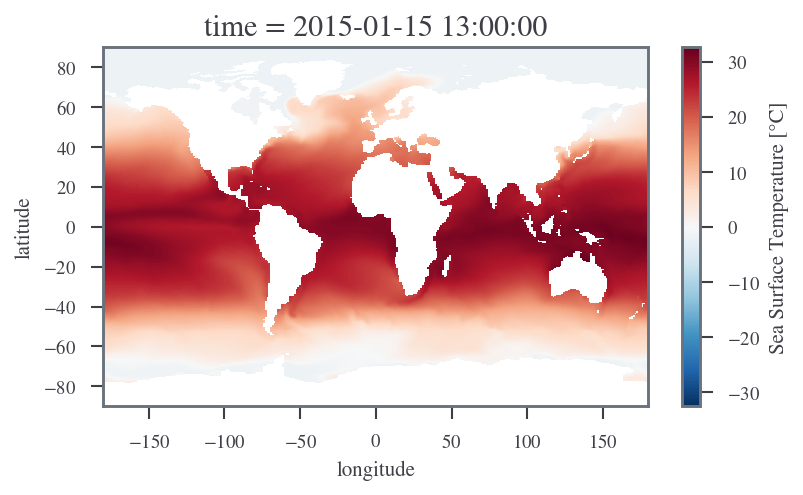

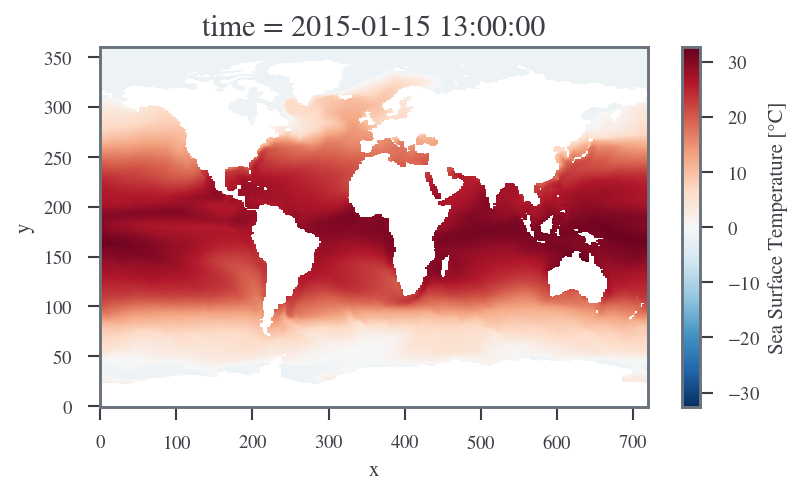

'regrid_any'  21 min 52 s 

Regridding ssp585.ocean.CESM2.r10i1p1f1
'open_ds'  4.62982 s 

in_ds <xarray.Dataset> Size: 13MB
Dimensions:        (time: 10, y: 384, x: 320, bnds: 2, vertex: 4)
Coordinates:
    lat            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time           (time) object 80B 2015-01-15 13:00:00 ... 2015-10-15 12:00:00
    time_bounds    (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 983kB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 983kB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
Dimensions without coordinates: y, x, bnds, vert

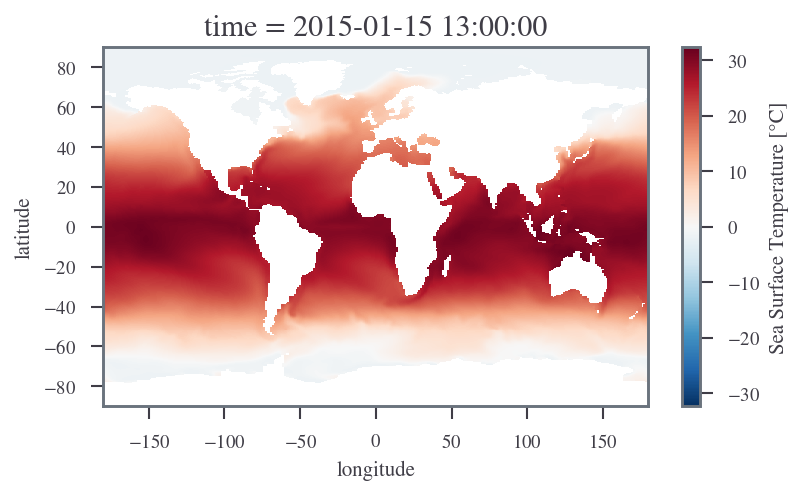

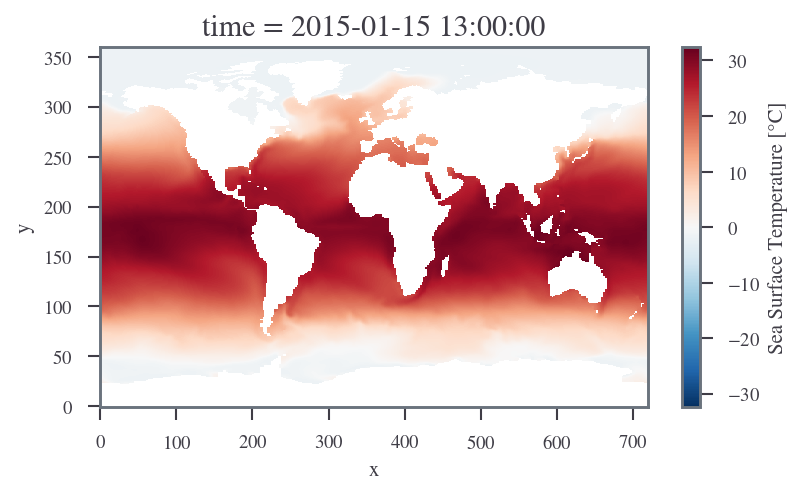

'regrid_any'  20 min 32 s 

Regridding ssp585.ocean.CESM2.r11i1p1f1
'open_ds'  8.50209 s 

in_ds <xarray.Dataset> Size: 13MB
Dimensions:        (time: 10, y: 384, x: 320, bnds: 2, vertex: 4)
Coordinates:
    lat            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time           (time) object 80B 2015-01-15 13:00:00 ... 2015-10-15 12:00:00
    time_bounds    (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 983kB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 983kB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
Dimensions without coordinates: y, x, bnds, vert

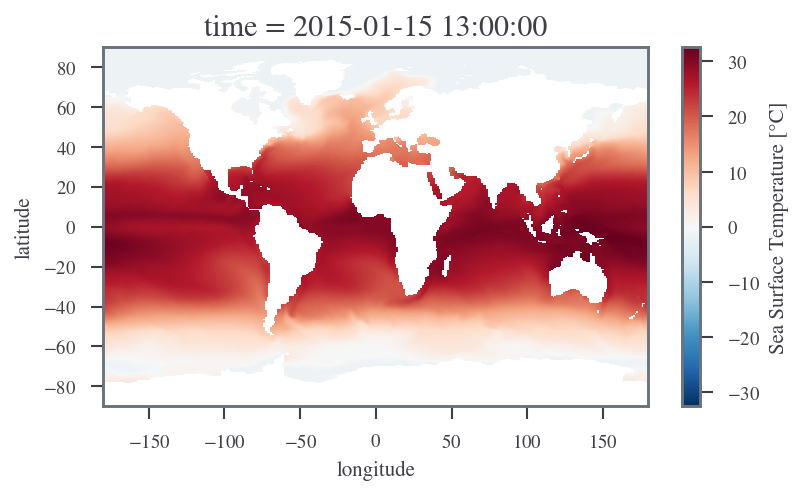

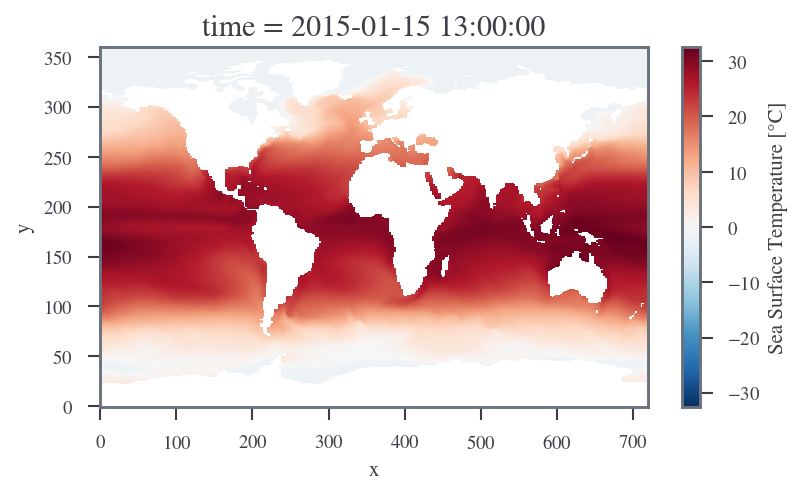

'regrid_any'  17 min 38 s 

Regridding ssp585.ocean.CIESM.r1i1p1f1
'open_ds'  2.35663 s 

in_ds <xarray.Dataset> Size: 19MB
Dimensions:        (time: 10, y: 384, x: 320, vertex: 4, bnds: 2)
Coordinates:
    lat            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon            (y, x) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time           (time) object 80B 2015-01-16 12:00:00 ... 2015-10-16 12:00:00
    lat_verticies  (y, x, vertex) float64 4MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 4MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bounds    (time, bnds) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 2MB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 2MB dask.array<chunksize=(2, 384, 320), meta=np.ndarray>
Dimensions without coordinates: y, x, vertex, bnds
Da

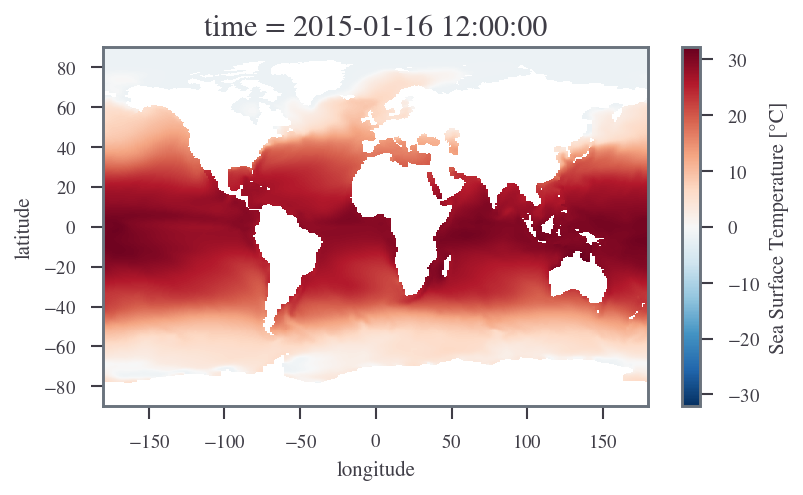

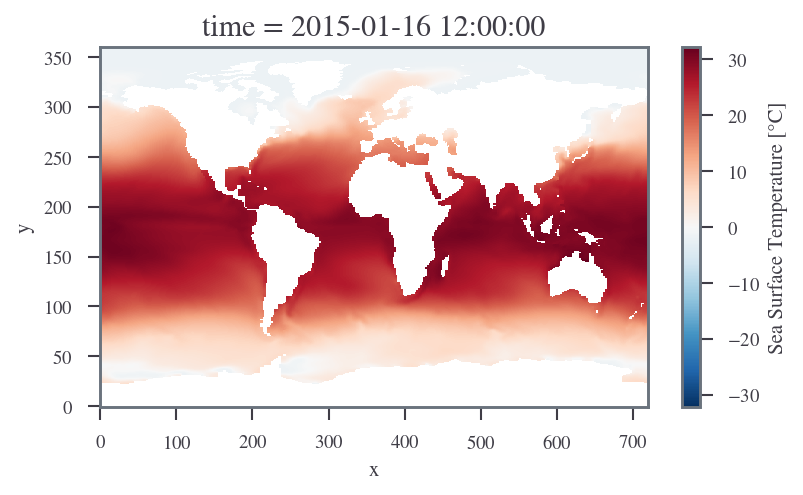

'regrid_any'  19 min 20 s 

Regridding ssp585.atmos.CESM2.r4i1p1f1
'open_ds'  1.37863 s 

in_ds <xarray.Dataset> Size: 89MB
Dimensions:      (time: 10, plev: 19, y: 192, x: 288, nbnd: 2)
Coordinates:
  * plev         (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
  * time         (time) object 80B 2015-01-15 12:00:00 ... 2015-10-15 12:00:00
    lat_bounds   (y, nbnd, x) float64 885kB dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds  (time, nbnd) object 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon_bounds   (x, nbnd, y) float64 885kB dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
  * nbnd         (nbnd) int64 16B 0 1
    lon          (x, y) float64 442kB dask.array<chunksize=(288, 192), meta=np.ndarray>
    lat          (x, y) float64 442kB dask.array<chunksize=(288, 192), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    hus          (time, plev, y, x) float32 42MB dask.array<chunksize=(10, 2, 12, 36), meta=np.

In [1]:
from tcpips.regrid import run_tasks
run_tasks(force_regrid=True, output_res=0.5)